# Are some features responsibles for encoding synonymy ?

In [1]:
import sklearn

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import graphviz
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from random import shuffle

import gensim

from gensim.models import KeyedVectors

import nltk

from nltk.corpus import wordnet as wn

nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [2]:
#get infos in wordnet
def get_wornet_synonyms_hypernyms(noun, words_filter=None):
    """Return le list of hypernyms and hyponyms of a word from wordvec.
    
    :param noun: the noun to find some synonyms
    :param words_filter: a list, if not None, return only words contained in this list

    :type noun: str
    :type words_filter: list(str)

    :return: a list of synonyms 
    :rtype: list(str)
    """
    try:
        hypernyms = wn.synsets(noun)[0].hypernyms()[0].lemma_names() #NB: on ne prend que le premier
    except:
        hypernyms = []
    try:
        hyponyms = wn.synsets(noun)[0].hyponyms()[0].lemma_names() #NB: on ne prend que le premier
    except:
        hyponyms = []
    if words_filter:
        out = []
        for w in hypernyms + hyponyms:
            if w in words_filter:
                out.append(w)
        return out
    return hypernyms + hyponyms

def get_wornet_synonyms(noun, words_filter=None):
    """Return le list of synonyms of a word from wordvec.
    
    :param noun: the noun to find some synonyms
    :param words_filter: a list, if not None, return only words contained in this list

    :type noun: str
    :type words_filter: list(str)

    :return: a list of synonyms 
    :rtype: list(str)
    """
    try:
        w = []
        for sn in wn.synsets(noun): 
            #TODO: check if the synset is a nouns synset and not verbs 
            #DONE: si on passe les mots qui sont des nomns seulemnt dans words_filter
            w.extend(sn.lemma_names())
    except:
        w = []
    w = list(set(w))
    return list(filter(lambda s: s in words_filter, w)) if words_filter else w



def similar_word2vec_words(word_vectors, noun, words_filter=None, n=10):
    """Return a list of the `n` most similar words from word2vec.
    
    :param word_vectors: the gensim word2vec model
    :param noun: the noun to find some similar words
    :param words_filter: a list, if not None, return only words contained in this list
    :param n: only return this number of words (max)

    :type word_vectors: gensim.models.keyedvectors.Word2VecKeyedVector
    :type noun: str
    :type words_filter: list(str)
    :type n: int
    
    :return: a list of similar meaning words
    :rtype: list(str)
    """
    tmp = list(list(zip(*word_vectors.similar_by_word(noun, n)))[0])
    if not words_filter:
        return tmp
    return list(filter(lambda s: s in words_filter, tmp))

def get_positive_and_negatives_synonyms_pairs(word_vectors, noun, words_filter=None, n=20):
    """Return 2 lists containing the synonyms int the first, 
    and similiars words in the second.
    
    :param word_vectors: the gensim word2vec model
    :param noun: the noun to find some similar words
    :param words_filter: a list, if not None, return only words contained in this list
    :param n: only return this number of words (max)
    
    :type word_vectors: gensim.models.keyedvectors.Word2VecKeyedVector
    :type noun: str
    :type words_filter: list(str)
    :type n: int
    
    :return: a tuple containg 2 lists: ([synonyms], [similars])
    :rtype: tuple(list(str), list(str))
    """
    synonyms = get_wornet_synonyms(noun, words_filter=words_filter)
    similars = similar_word2vec_words(word_vectors, noun, words_filter=words_filter)
    not_synonyms = list(filter(lambda s: not s in synonyms, similars))
    return synonyms, not_synonyms

#list all word2vec nouns exploitables
def is_exploitable(s):
    """not accept urls, names, patterns and weird stuffs... 
    AND is in wordnet database !!"""
    if s != s.lower():
        return False
    for c in '._+#/@':
        if c in s:
            return False
    #simple heuristic: remove all words ending with 's' to get only singular nouns
    if s[-1] == 's':
        return False
    if s.isalpha():
        return wn.synsets(s) != [] #check if is in wordnnet databse


In [3]:
try:
    positives = np.load("positives.npy")
    negatives = np.load("negatives.npy")
except:
    print("* load word2vec pretrained from google")
    word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

    print("* load nouns")

    print(" - list all wordnet nouns")
    wordnet_nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

    print(" - build a list of exploitable words")
    words = list(filter(is_exploitable, word_vectors.index2word))
    words = list(filter(lambda s: s in wordnet_nouns, words))

    #example
    synonyms, not_synonyms = get_positive_and_negatives_synonyms_pairs(word_vectors, "dog", words)

    print("* build a dataset of synonyms / not synonyms")
    positives = []
    negatives = []

    allready_seen_words = [] #allow us to remove some simple duplicates

    shuffle(words)

    nb_max_words = len(words)

    print(" - build pairs")
    for word in tqdm(words[:nb_max_words]):
        if word in allready_seen_words:
            continue
        allready_seen_words.append(word)
        pos, neg = get_positive_and_negatives_synonyms_pairs(word_vectors, word, words)
        for p in pos:
            positives.append((word, p))
        for n in neg:
            negatives.append((word, n))

    np.save("positives", np.array(positives))
    np.save("negatives", np.array(negatives))

positives = list(positives)
negatives = list(negatives)

shuffle(positives)
shuffle(negatives)

positives = np.array(positives)
negatives = np.array(negatives)

In [4]:
positives, negatives

(array([['nursing', 'nursing'],
        ['much', 'much'],
        ['vitrification', 'vitrification'],
        ...,
        ['hallelujah', 'hallelujah'],
        ['extrusion', 'excrescence'],
        ['serration', 'serration']], dtype='<U31'),
 array([['plagiocephaly', 'myelomeningocele'],
        ['chauvinism', 'provincialism'],
        ['planner', 'accountant'],
        ...,
        ['icecap', 'glacier'],
        ['mystique', 'allure'],
        ['hitler', 'hillary']], dtype='<U29'))

In [5]:
try:
    positive_embedings = np.load("positive_embedings.npy")
    negative_embedings = np.load("negative_embedings.npy")
except:
    print(" - compute embedings")
    positive_embedings = np.array(list(map(
        lambda c: [word_vectors.word_vec(c[0]), word_vectors.word_vec(c[1])], 
        positives
    )))

    negative_embedings = np.array(list(map(
        lambda c: [word_vectors.word_vec(c[0]), word_vectors.word_vec(c[1])], 
        negatives
    )))
    
    np.save("positive_embedings", positive_embedings)
    np.save("negative_embedings", negative_embedings)

positive_embedings = list(positive_embedings)
negative_embedings = list(negative_embedings)

shuffle(positive_embedings)
shuffle(negative_embedings)

positive_embedings = np.array(positive_embedings)
negative_embedings = np.array(negative_embedings)

In [6]:
#keep the same number of positive vs negatives
nb_max_rows = min(len(positives), len(negatives))

positive_train = positive_embedings[:int(nb_max_rows * .8)]
positive_test  = positive_embedings[int(nb_max_rows * .8):nb_max_rows]

negative_train = negative_embedings[:int(nb_max_rows * .8)]
negative_test  = negative_embedings[int(nb_max_rows * .8):nb_max_rows]

In [7]:
print(" - split dataset in training/test sets")
x_train = np.array(list(positive_train) + list(negative_train))
y_train = np.array([0] * len(positive_train) + [1] * len(negative_train)) #0 means synonym

x_test = np.array(list(positive_test) + list(negative_test))
y_test = np.array([0] * len(positive_test) + [1] * len(negative_test))

 - split dataset in training/test sets


In [8]:
print(" - augment the dataset by adding the symetry")
#adding a symetry to the dataset let us to augment data for free 
#and remove some noise (the anchor words is not allways on the same side...)
build_symetry = lambda x_set : np.array([x_set[:, 0, :], x_set[:, 1, :]]).swapaxes(0, 1)

assert (build_symetry(build_symetry(x_train)) == x_train).mean() == 1. #check the axis stuff

x_train = np.array(list(x_train) + list(build_symetry(x_train)))
x_test  = np.array(list(x_test)  + list(build_symetry(x_test)))

y_train = np.array(list(y_train) + list(y_train))
y_test  = np.array(list(y_test)  + list(y_test))

 - augment the dataset by adding the symetry


In [9]:
print(" - difference")
#substract w1 - w2 to get a difference of words to find if there is a dimension which encode synonymy
x_train_method_1 = x_train[:, 0, :] - x_train[:, 1, :]
x_test_method_1  = x_test[:, 0, :]  - x_test[:, 1, :]


print(" - cosine 'difference'")

#build a difference function inspired by the cosine distance
def diff(a, b):
    c = a * b
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return c / (norm_a * norm_b)

L = []
for i in trange(x_train.shape[0]):
    L.append(diff(x_train[i, 0, :], x_train[i, 1, :]))
x_train_method_2 = np.array(L)

L = []
for i in trange(x_test.shape[0]):
    L.append(diff(x_test[i, 0, :], x_test[i, 1, :]))
x_test_method_2 = np.array(L)

  0%|          | 0/131104 [00:00<?, ?it/s]

 - difference
 - cosine 'difference'


100%|██████████| 32776/32776 [00:01<00:00, 27915.40it/s]


In [11]:
print(" - shuffle data")

#for method 1
data_train_method_1 = list(zip(x_train_method_1, y_train))
data_test_method_1  = list(zip(x_test_method_1,  y_test))

shuffle(data_train_method_1)
shuffle(data_test_method_1)

x_train_method_1, y_train_method_1 = list(zip(*data_train_method_1))
x_test_method_1,  y_test_method_1  = list(zip(*data_test_method_1))

x_train_method_1 = np.array(x_train_method_1)
y_train_method_1 = np.array(y_train_method_1)
x_test_method_1  = np.array(x_test_method_1)
y_test_method_1  = np.array(y_test_method_1)

#for method 2
data_train_method_2 = list(zip(x_train_method_2, y_train))
data_test_method_2  = list(zip(x_test_method_2,  y_test))

shuffle(data_train_method_2)
shuffle(data_test_method_2)

x_train_method_2, y_train_method_2 = list(zip(*data_train_method_2))
x_test_method_2,  y_test_method_2  = list(zip(*data_test_method_2))

x_train_method_2 = np.array(x_train_method_2)
y_train_method_2 = np.array(y_train_method_2)
x_test_method_2  = np.array(x_test_method_2)
y_test_method_2  = np.array(y_test_method_2)

 - shuffle data


## Train models and look what they learnt

In [12]:
#normalize features
mean_method_1, std_method_1 = x_train_method_1.mean(0), x_train_method_1.std(0)
x_train_method_1 = (x_train_method_1 - mean_method_1) / std_method_1
x_test_method_1  = (x_test_method_1  - mean_method_1) / std_method_1

mean_method_2, std_method_2 = x_train_method_2.mean(0), x_train_method_2.std(0)
x_train_method_2 = (x_train_method_2 - mean_method_2) / std_method_2
x_test_method_2  = (x_test_method_2  - mean_method_2) / std_method_2


In [16]:
print("training linear model")

#method 1
logistic_regression_method_1 = LogisticRegression(penalty='l1', C=0.05)
logistic_regression_method_1.fit(x_train_method_1, y_train_method_1)

acc_method_1 = (logistic_regression_method_1.predict(x_test_method_1) == y_test_method_1).mean()
print("synonyms calssification accuracy (method 1): ", acc_method_1 * 100, " %")

#method 2
logistic_regression_method_2 = LogisticRegression(penalty='l1', C=0.05)
logistic_regression_method_2.fit(x_train_method_2, y_train_method_2)

acc_method_2 = (logistic_regression_method_2.predict(x_test_method_2) == y_test_method_2).mean()
print("synonyms calssification accuracy (method 2): ", acc_method_2 * 100, " %")

training linear model
synonyms calssification accuracy (method 1):  66.86599951183793  %
synonyms calssification accuracy (method 2):  67.37856968513547  %


10 most important features :  [150 288 126  55  74 233 170  87 198 118]


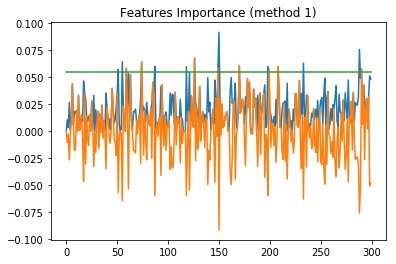

In [18]:
coefs = logistic_regression_method_1.coef_[0]

plt.title("Features Importance (method 1)")
plt.plot(abs(coefs))
plt.plot(coefs)

print("10 most important features : ", abs(coefs).argsort()[::-1][:10])

#set a threshold
t = abs(coefs)
t = t.mean() + t.std() * 2
plt.plot([t] * len(coefs))

plt.show()

10 most important features :  [139 289 150 271   3   1 298  92 210 251]


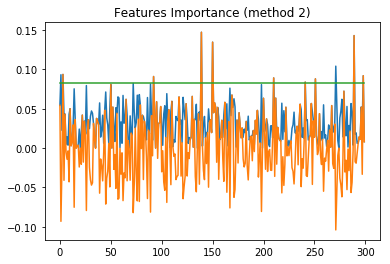

In [19]:
coefs = logistic_regression_method_2.coef_[0]

plt.title("Features Importance (method 2)")
plt.plot(abs(coefs))
plt.plot(coefs)

print("10 most important features : ", abs(coefs).argsort()[::-1][:10])

#set a threshold
t = abs(coefs)
t = t.mean() + t.std() * 2
plt.plot([t] * len(coefs))

plt.show()

==> ___The 2 methods aggree on the importance of the feature `#150`...___


In [21]:
print("decision tree")

#method 1
dt_clf_method_1 = DecisionTreeClassifier(max_depth=3)
dt_clf_method_1.fit(x_train_method_1, y_train_method_1)

acc = (dt_clf_method_1.predict(x_test_method_1) == y_test_method_1).mean()
print("synonyms calssification accuracy (method 1): ", acc * 100, " %")

#method 2
dt_clf_method_2 = DecisionTreeClassifier(max_depth=3)
dt_clf_method_2.fit(x_train_method_2, y_train_method_2)

acc = (dt_clf_method_2.predict(x_test_method_2) == y_test_method_2).mean()
print("synonyms calssification accuracy (method 2): ", acc * 100, " %")

decision tree
synonyms calssification accuracy (method 1):  72.85818891872101  %
synonyms calssification accuracy (method 2):  58.18281669514279  %


In [30]:
def print_decision_tree(tree, feature_names=None, offset_unit='    '):
    '''Plots textual representation of rules of a decision tree
    tree: scikit-learn representation of tree
    feature_names: list of feature names. They are set to f1,f2,f3,... if not specified
    offset_unit: a string of offset of the conditional block'''

    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    if feature_names is None:
        features  = ['f%d'%i for i in tree.tree_.feature]
    else:
        features  = [feature_names[i] for i in tree.tree_.feature]        

    def recurse(left, right, threshold, features, node, depth=0):
            offset = offset_unit*depth
            if (threshold[node] != -2):
                    print(offset+"if ( " + features[node] + " <= " + str(threshold[node]) + " ) :")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node],depth+1)
                    print(offset+"else ")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node],depth+1)
                    print(offset+"")
            else:
                    print(offset+"return " + str(value[node]))

    recurse(left, right, threshold, features, 0,0)

print_decision_tree(dt_clf_method_1)

if ( f149 <= -0.024356726557016373 ) :
    if ( f149 <= -0.02704571932554245 ) :
        if ( f149 <= -1.482656478881836 ) :
            return [[4926. 4250.]]
        else 
            return [[13670. 26730.]]
        
    else 
        if ( f58 <= -0.024332841858267784 ) :
            return [[22. 74.]]
        else 
            return [[29136.    40.]]
        
    
else 
    if ( f4 <= 1.57061767578125 ) :
        if ( f93 <= 1.3512747287750244 ) :
            return [[12832. 30122.]]
        else 
            return [[2650. 2630.]]
        
    else 
        if ( f4 <= 2.1399245262145996 ) :
            return [[1158. 1200.]]
        else 
            return [[1158.  506.]]
        
    



feature	importance
149	0.9474222737176119
4	0.027835250180013177
93	0.019151579967764766
58	0.005590896134610115


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


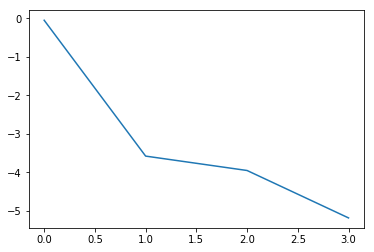

In [25]:
feature_importances = dt_clf_method_1.feature_importances_.argsort()[::-1]
print("feature\timportance")
for fi in feature_importances:
    t = dt_clf_method_1.feature_importances_[fi]
    if  t > 0:
        print(str(fi) + "\t" + str(t))
    else:
        break

plt.plot(np.log(sorted(dt_clf_method_1.feature_importances_)[::-1]))
plt.show()

The decision tree was __73.34%__ accurate with the simple embeddings difference and now only __64.07%__ accurate... 

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=10, max_depth=1, verbose=1)
gbc.fit(x_train_method_1, y_train_method_1)

acc = (gbc.predict(x_test_method_1) == y_test_method_1).mean()
print("synonyms calssification accuracy (method 1): ", acc * 100, " %")


      Iter       Train Loss   Remaining Time 
         1           1.3735           15.88s
         2           1.3614           13.46s
         3           1.3497           11.60s
         4           1.3388            9.87s
         5           1.3283            8.16s
         6           1.3182            6.53s
         7           1.3086            4.96s
         8           1.2994            3.29s
         9           1.2905            1.64s
        10           1.2820            0.00s
synonyms calssification accuracy (method 1):  69.15425921405907  %


In [58]:
a = np.where(gbc.feature_importances_ > 0)[0]
b = sorted([150, 288, 126, 55, 74, 233, 170,  87, 198, 118])# + [139, 289, 150, 271, 3, 1, 298, 92, 210, 251])

a = set(a)
b = set(b)

a.intersection(b)

{74, 126, 150, 198, 233}